In [2]:
dataset = "agnews"
model = "distilbert"

train_time_dict = {"fedFwd":0.669904}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.875
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['g','b','y','m','k'] * 100
lw = 5

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

param_num: 102916
fedFwd_bert_agnews_lr0.01_client_num_1000_numerical_max_1_percent.log
6.641856272460933
param_num: 102916
fedFwd_bert_agnews_lr0.01_client_num_1000_numerical_max_10_percent.log
4.673898858398436
param_num: 102916
fedFwd_bert_agnews_lr0.01_client_num_1000_numerical_check_20_cdq.log
5.6578775654296845
param_num: 102916
fedFwd_bert_agnews_lr0.01_client_num_1000_numerical_check_40_cdq.log
5.16588821191406
param_num: 105988
fedFwd_bert_agnews_lr0.01_client_num_1000_numerical.log
10.926890777343743


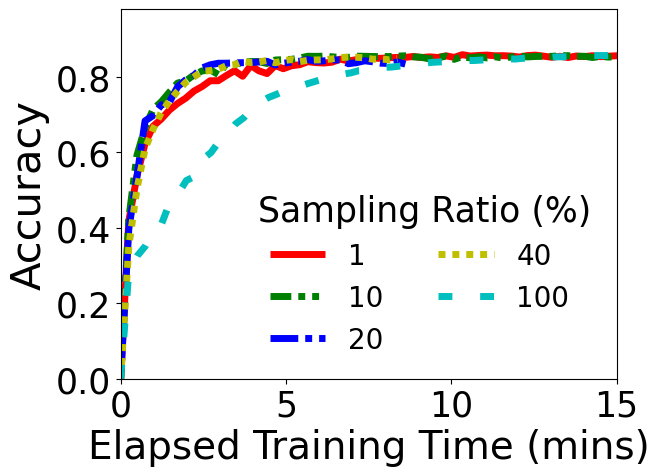

In [7]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np

eval_frequence = 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 5

file_list = [
    "fedFwd_bert_agnews_lr0.01_client_num_1000_numerical_max_1_percent.log",
    "fedFwd_bert_agnews_lr0.01_client_num_1000_numerical_max_10_percent.log",
    "fedFwd_bert_agnews_lr0.01_client_num_1000_numerical_check_20_cdq.log",
    "fedFwd_bert_agnews_lr0.01_client_num_1000_numerical_check_40_cdq.log",
    "fedFwd_bert_agnews_lr0.01_client_num_1000_numerical.log"
]

for i,file in enumerate(file_list):
    if file.endswith(".log"):
        acc = [0]
        with open(file,"r") as f:
            for line in f:
                if "Trainable" in line:
                    param_num = int(line[line.rfind(":")+2:-2])
                    print(f"param_num: {param_num}")
                    break
            comm_time = param_num * 4 / comm_bandwidth
            log = f.readlines()
            for l in log:
                if "'acc':" in l:
                    acc.append(float(l[l.rfind("'acc':")+7:l.rfind(",")]))
                # if len(acc)>200:
                #     break
            method = file.split("_")[0]
            label_list = ['1','10','20','40','100']
            print(file)
            print(get_time_to_target_acc(0.845,acc,round_to_time(len(acc),eval_frequence,comm_time,method,15,None)))
            plt.plot(round_to_time(len(acc),eval_frequence,comm_time,method,15,None), acc, linestyle=linestyle[i], color=colors[i],label=label_list[i],linewidth=lw)

plt.xlabel("Elapsed Training Time (mins)",fontsize=28)
plt.ylabel("Accuracy",fontsize=30)
plt.xticks(range(0,21,5),size = 25)
plt.xlim(0,15)
plt.yticks(np.arange(0,0.9,0.2),size = 25)
plt.ylim(0,0.98)
plt.legend(fontsize=20,title=' Sampling Ratio (%)',title_fontsize=25,ncol=2,frameon=False)
plt.savefig('/data/wyz/ForwardFL-Latex/figs/eval-ablation-sampling-bert-agnews.pdf', bbox_inches="tight")
# plt.title(f"bert agnews",fontsize=30)
plt.show()